In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import librosa.display as lrdisplay
import librosa.feature as lrfeature

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as skmetrics

import vxs
import vxs.utils as vxsu

In [2]:
avp_set_fixed = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed', recordings_type='hits')
avp_segments_fixed = vxs.SegmentSet(avp_set_fixed)

In [3]:
len(avp_segments_fixed)

3316

In [11]:
def unzip_dataset(dataset):
    X = []
    y = []
    for features, label in dataset:
        X.append(features)
        y.append(label)
    return X, y

In [12]:
X, y = unzip_dataset(avp_segments_fixed)

In [13]:
len(X)

3316

In [14]:
avp_set_personal = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Personal', recordings_type='hits')
avp_segments_personal = vxs.SegmentSet(avp_set_personal)

In [15]:
len(avp_segments_personal)

2874

In [16]:
X_test, y_test = unzip_dataset(avp_segments_personal)

In [17]:
model_mfcc = vxs.make_knn_classic('mfcc')
model_mfcc.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='mfcc')),
                ('normalizer', Normalizer()), ('knn', KNeighborsClassifier())])

In [18]:
for k in [3, 5, 7, 10, 15]:
    model = model_mfcc.set_params(knn__n_neighbors=k)
    y_pred = model.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, y_pred)
    print(f'{k} neighbors: {acc}')

3 neighbors: 0.5501043841336117
5 neighbors: 0.5494084899095337
7 neighbors: 0.5448851774530271
10 neighbors: 0.5480167014613778
15 neighbors: 0.5556715379262352


In [19]:
model_mfcc.set_params(knn__weights='distance')
for k in [3, 5, 7, 10, 15]:
    model = model_mfcc.set_params(knn__n_neighbors=k)
    y_pred = model.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, y_pred)
    print(f'{k} neighbors: {acc}')

3 neighbors: 0.5438413361169102
5 neighbors: 0.5490605427974948
7 neighbors: 0.545929018789144
10 neighbors: 0.5504523312456506
15 neighbors: 0.5549756437021572


In [20]:
y_pred = model_mfcc.predict(X_test)

In [21]:
skmetrics.confusion_matrix(y_test, y_pred)

array([[518,  90,  29,  75],
       [350, 273,  31,  72],
       [ 73,  35, 521,  81],
       [194, 217,  32, 283]])

In [22]:
skmetrics.accuracy_score(y_test, y_pred)

0.5549756437021572

### Ramires features

In [21]:
model_ramires = vxs.make_knn_classic('ramires')
model_ramires.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='ramires')),
                ('normalizer', Normalizer()), ('knn', KNeighborsClassifier())])

In [22]:
y_pred2 = model_ramires.predict(X_test)

In [23]:
skmetrics.confusion_matrix(y_test, y_pred2)

array([[534, 243,  99, 159],
       [402, 343,  66,  87],
       [240,  45, 726, 262],
       [403, 336,  52, 309]])

In [24]:
skmetrics.accuracy_score(y_test, y_pred2)

0.4440315838365072

### Autoencoder features

In [97]:
model = vxs.get_CAE_model('square-1', '../logs/cae-initial_65536_square-1/checkpoints/best.pth')
encoder = model.encoder
encoder.eval()
model_cae = vxs.make_knn_cae(encoder)

In [98]:
model_cae.fit(X, y)

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn', KNeighborsClassifier())])

In [99]:
y_pred3 = model_cae.predict(X_test)

In [30]:
skmetrics.confusion_matrix(y_test, y_pred3)

array([[ 697,  159,   81,   98],
       [ 366,  397,   48,   87],
       [ 130,   25, 1004,  114],
       [ 278,  328,  121,  373]])

In [31]:
skmetrics.accuracy_score(y_test, y_pred3)

0.5738504412447747

In [100]:
model_wide = vxs.get_CAE_model('wide-4', '../logs/cae-initial_65536_wide-4/checkpoints/best.pth')
model_wide.eval()
model_cae_wide = vxs.make_knn_cae(model_wide.encoder)

In [101]:
model_cae_wide.fit(X, y)

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 5), stride=(2, 2), padding=(1, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn', KNeighborsClassifier())])

In [34]:
y_pred4 = model_cae_wide.predict(X_test)

In [35]:
skmetrics.confusion_matrix(y_test, y_pred4)

array([[673, 186,  68, 108],
       [348, 412,  50,  88],
       [138,  17, 956, 162],
       [285, 295,  85, 435]])

In [36]:
skmetrics.accuracy_score(y_test, y_pred4)

0.5750116117045982

In [37]:
ftfm = model_cae_wide.named_steps['cae_features']
ftfm.transform(X[:5])[0].shape

(32,)

In [38]:
ftfm_big = model_cae.named_steps['cae_features']
ftfm_big.transform(X[:5])[0].shape

(256,)

### Segmentation + classification

In [82]:
avp_fixed_improvs = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Fixed', recordings_type='improvs')
len(avp_fixed_improvs)

28

In [60]:
track_10, anno_10 = avp_fixed_improvs.get('P10_Improvisation_Fixed')

In [96]:
vxsu.play_audio(track_10)

In [61]:
lang_model = vxs.load_model_from_bundle('../data/drum_kit_rnn.mag')

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmplyf0wa0x/model_drum_kit.ckpt


In [62]:
analysis_result_nolang = vxs.segment_classify(track_10, model_mfcc)
analysis_result_lang = vxs.segment_classify(track_10, model_mfcc, lang_model)

INFO:tensorflow:Beam search yields sequence with log-likelihood: -149.888092 


In [63]:
import note_seq
note_seq.plot_sequence(analysis_result_lang['note_seq'])

Loading BokehJS ...

In [64]:
resulting_sound = vxs.Track(note_seq.fluidsynth(analysis_result_lang['note_seq'], sample_rate=44100))

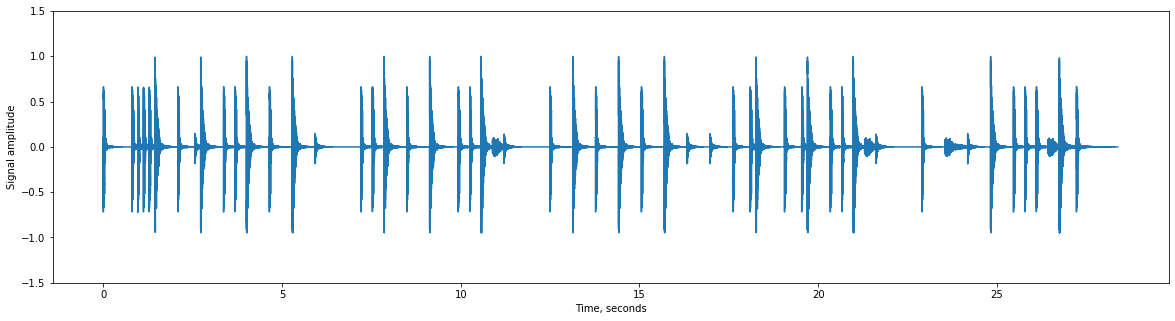

In [65]:
vxsu.plot_track(resulting_sound)

In [66]:
vxsu.play_audio(resulting_sound)

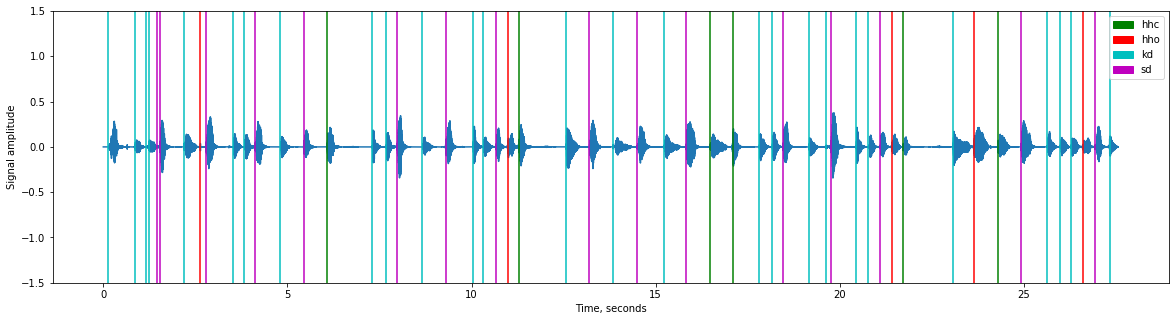

In [67]:
vxsu.plot_track(track_10, analysis_result_nolang['onsets'], color_events=True)

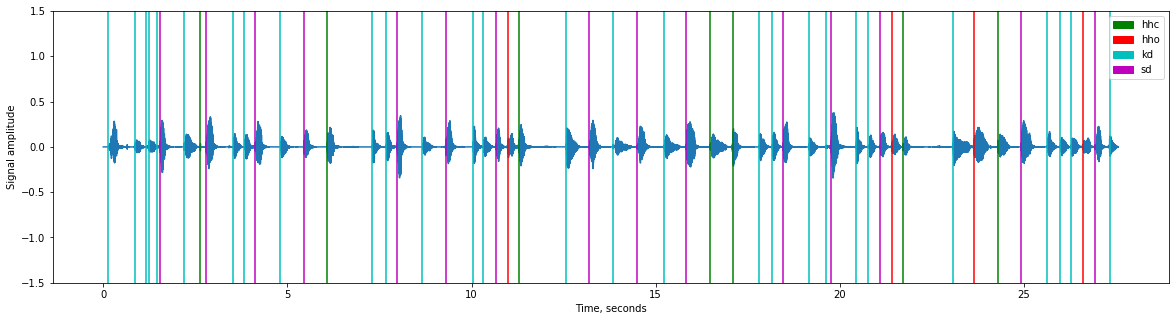

In [68]:
vxsu.plot_track(track_10, analysis_result_lang['onsets'], color_events=True)

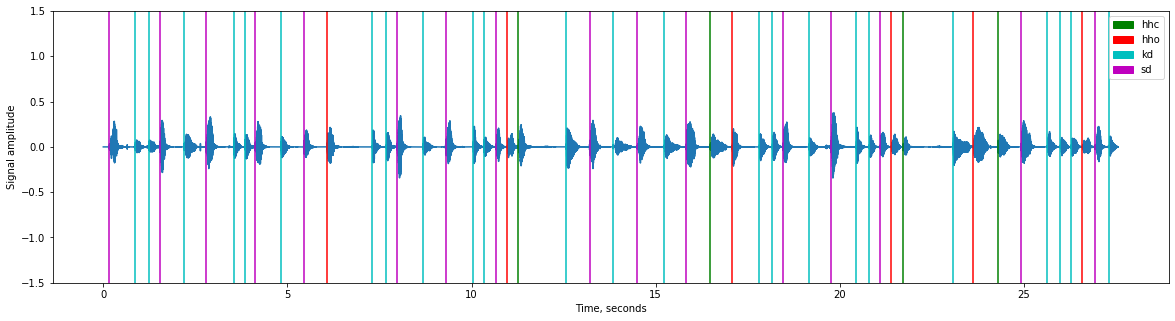

In [69]:
vxsu.plot_track(track_10, anno_10, color_events=True)

In [70]:
vxs.classes_F1_score(analysis_result_nolang['onsets'], anno_10, ms_threshold=50)

hhc  hho  kd  sd  sil
hhc    4    0   0   0    0
hho    2    4   0   0    0
kd     0    0  24   0    0
sd     0    0   1  15    0
sil    0    1   2   1    0

In [71]:
vxs.classes_F1_score(analysis_result_lang['onsets'], anno_10, ms_threshold=50)

hhc  hho  kd  sd  sil
hhc    4    0   0   0    0
hho    2    4   0   0    0
kd     0    0  24   0    0
sd     0    0   1  15    0
sil    1    0   3   0    0

In [121]:
def segment_classify_all(trackset, model, lang_model=None, verbose=False, **kwargs):
    total_cf = None
    for i, (track, anno) in enumerate(trackset.annotated_tracks()):
        analysis = vxs.segment_classify(track, model, lang_model, **kwargs)
        cf = vxs.classes_F1_score(analysis['onsets'], anno)
        
        if total_cf is None:
            total_cf = cf
        else:
            total_cf = total_cf.add(cf, fill_value=0)
            
        if verbose:
            print(f'track {i} done')
    
    if 'pm' in total_cf.columns:
        total_cf = total_cf.drop('pm', 0).drop('pm', 1)
    if '' in total_cf.columns:
        total_cf = total_cf.drop('', 0).drop('', 1)
    
    scores = vxs.cf_to_prec_rec_F1(total_cf)
    
    return total_cf, scores

In [88]:
%%time
mfcc_cf, mfcc_scores = segment_classify_all(avp_fixed_improvs, model_mfcc, verbose=True)

track 0 done
track 1 done
track 2 done
track 3 done
track 4 done
track 5 done
track 6 done
track 7 done
track 8 done
track 9 done
track 10 done
track 11 done
track 12 done
track 13 done
track 14 done
track 15 done
track 16 done
track 17 done
track 18 done
track 19 done
track 20 done
track 21 done
track 22 done
track 23 done
track 24 done
track 25 done
track 26 done
track 27 done
CPU times: user 50 s, sys: 31 s, total: 1min 21s
Wall time: 23.2 s


In [89]:
mfcc_cf

hhc    hho     kd     sd   sil
hhc  252.0   17.0    7.0   12.0  20.0
hho   81.0  281.0    0.0    0.0   4.0
kd     9.0    3.0  482.0   20.0  32.0
sd    17.0    2.0    4.0  331.0  11.0
sil   33.0   24.0   50.0   23.0   0.0

In [90]:
mfcc_scores

prec       rec        F1
hhc  0.818182  0.642857      0.72
hho   0.76776  0.859327  0.810967
kd   0.882784  0.887661  0.885216
sd   0.906849  0.857513  0.881491

In [91]:
mfcc_scores.mean()

prec    0.843894
rec     0.811840
F1      0.824418
dtype: float64

In [122]:
%%time
mfcc_lm_cf, mfcc_lm_scores = segment_classify_all(avp_fixed_improvs, model_mfcc, lang_model, verbose=True,
                                                  temperature=1.2, beam_size=10, branch_factor=10)

INFO:tensorflow:Beam search yields sequence with log-likelihood: -115.264580 
track 0 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -98.784027 
track 1 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -198.904541 
track 2 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -144.606201 
track 3 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -118.524529 
track 4 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -113.658020 
track 5 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -174.321579 
track 6 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -121.085136 
track 7 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -246.195969 
track 8 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -151.847565 
track 9 done
INFO:tensorflow:Beam search yields sequence with log-likelihood: -155.060074 
track 10 done

In [123]:
mfcc_lm_cf

hhc    hho     kd     sd   sil
hhc  252.0   15.0    5.0   16.0  20.0
hho  123.0  238.0    0.0    1.0   4.0
kd    10.0    1.0  482.0   21.0  32.0
sd    15.0    0.0    8.0  331.0  11.0
sil   30.0   16.0   52.0   32.0   0.0

In [124]:
mfcc_lm_scores

prec       rec        F1
hhc  0.818182  0.586047  0.682927
hho  0.650273  0.881481  0.748428
kd   0.882784   0.88117  0.881976
sd   0.906849  0.825436   0.86423

In [125]:
mfcc_lm_scores.mean()

prec    0.814522
rec     0.793534
F1      0.794390
dtype: float64

In [115]:
model_cae_wide.set_params(knn__weights='distance')
model_cae_wide.set_params(knn__n_neighbors=15)
model_cae_wide

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 5), stride=(2, 2), padding=(1, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [116]:
%%time
cwide_cf, cwide_scores = segment_classify_all(avp_fixed_improvs, model_cae_wide, verbose=True)

track 0 done
track 1 done
track 2 done
track 3 done
track 4 done
track 5 done
track 6 done
track 7 done
track 8 done
track 9 done
track 10 done
track 11 done
track 12 done
track 13 done
track 14 done
track 15 done
track 16 done
track 17 done
track 18 done
track 19 done
track 20 done
track 21 done
track 22 done
track 23 done
track 24 done
track 25 done
track 26 done
track 27 done
CPU times: user 1min, sys: 33.2 s, total: 1min 34s
Wall time: 26.5 s


In [117]:
cwide_cf

hhc    hho     kd     sd   sil
hhc  235.0   15.0   14.0   24.0  20.0
hho  152.0  208.0    0.0    2.0   4.0
kd    14.0    0.0  455.0   45.0  32.0
sd    19.0    6.0   62.0  267.0  11.0
sil   25.0   19.0   52.0   34.0   0.0

In [118]:
cwide_scores

prec       rec        F1
hhc  0.762987   0.52809   0.62417
hho  0.568306   0.83871  0.677524
kd   0.833333  0.780446  0.806023
sd   0.731507  0.717742  0.724559

In [119]:
cwide_scores.mean()

prec    0.724033
rec     0.716247
F1      0.708069
dtype: float64